## 3.2 线性回归的从零开始实现

在了解了线性回归的背景知识之后，现在我们可以动手实现它了。尽管强大的深度学习框架可以减少大量重复性工作，但若过于依赖它提供的便利，会导致我们很难深入理解深度学习是如何工作的。因此，本节将介绍如何只利用NDArray和autograd来实现一个线性回归的训练。

首先，导入本节中实验所需的包或模块，其中的matplotlib包可用于作图，且设置成嵌入显示。

#### 笔记_1：
#### Python模块 
* Python模块是扩展名为.py的文件，里面有函数、类(属性、方法)等。
* 导入语法：①from module_name import function_name；②from module_name import function_0，function_1，function_2；③from module_name import function_name as fn；④import module_name as mn；⑤from module_name import *
* module.function

#### Python包
* 在模块之上的概念，为了方便管理而将文件进行打包。包目录下第一个文件便是 **__init__.py**，然后是一些模块文件和子目录，假如子目录中也有 **__init__.py**，那么它就是这个包的子包了。
* 常见的包结构：
![package](./package.PNG)
* 导入语法：①from package.module import function；②from package.module import * ； ③import package.module
* package.module.function
#### Python库
* 具有相关功能的模块的集合。这也是Python的一大特色之一，即具有强大的标准库、第三方库以及自定义模块。
#### Python标准库
* 就是下载安装的python里那些自带的模块，要注意的是，里面有一些模块是看不到的，比如像sys模块，这与linux下的cd命令看不到是一样的情况。
#### Python第三方库
* 就是由其他的第三方机构发布的具有特定功能的模块。
#### Python自定义模块
* 用户自己可以自行编写模块，然后使用。

In [3]:
%matplotlib inline 
from IPython import display
from matplotlib import pyplot as plt
from mxnet import autograd, nd
import random

### 3.2.1 生成数据集

我们构造一个简单的人工训练数据集，它可以使我们能够直观比较学到的参数和真实的模型参数的区别。设训练数据集样本数为1000，输入个数(特征数)为2。给定随机生成的批量样本特征$\boldsymbol{X} \in \mathbb{R}^{1000 \times 2}$，我们使用线性回归模型真实权重$\boldsymbol{w} = [2, -3.4]^\top$和偏差$b = 4.2$，以及一个随机噪声项$\epsilon$来生成标签

$$\boldsymbol{y} = \boldsymbol{X}\boldsymbol{w} + b + \epsilon,$$

其中噪声项$\epsilon$服从均值为0、标准差为0.01的正态分布。噪声项代表了数据集中无意义的干扰。下面，让我们生成数据集。

In [6]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = nd.random.normal(loc=0, scale=1, shape=(num_examples, num_inputs)) # 均值为0，标准差为1
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += nd.random.normal(loc=0, scale=0.01, shape=labels.shape) # 均值为0，标准差为0.01

In [7]:
nd.random_normal?

In [9]:
features[0:10], labels[0:10]

(
 [[ 1.1630785   0.4838046 ]
  [ 0.29956347  0.15302546]
  [-1.1688148   1.5580711 ]
  [-0.5459446  -2.3556297 ]
  [ 0.5414402   2.6785066 ]
  [ 1.2546345  -0.54877394]
  [-0.68106437 -0.13531584]
  [ 0.37723127  0.41016445]
  [ 0.5712682  -2.7579627 ]
  [ 1.07628    -0.6141326 ]]
 <NDArray 10x2 @cpu(0)>,
 
 [ 4.879625   4.2968144 -3.4331124 11.099875  -3.8235698  8.576558
   3.3012054  3.564482  14.710667   8.445549 ]
 <NDArray 10 @cpu(0)>)

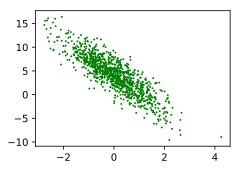

In [12]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')
    
def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize
    
set_figsize()
plt.scatter(features[:, 1].asnumpy(), labels.asnumpy(), s=1, c='g'); # 加分号只显示图

我们将上面的plt作图函数以及use_svg_display函数和set_figsize函数定义在d2lzh包里。以后在作图时，我们将直接调用d2lzh.plt。由于plt在d2lzh包里是一个全局变量，我们在作图前只需要调用d2lzh.set_figsize()即可打印矢量图并设置图的尺寸。

### 3.2.2 读取数据集


在训练模型的时候，我们需要遍历数据集并不断读取小批量数据样本。这里我们定义一个函数：它每次返回batch_size(批量大小)个随机样本的特征和标签。

In [34]:
# 本函数已保存在d2lzh包中方便以后使用
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    print(indices)
    random.shuffle(indices) # 样本的读取顺序是随机的
    print(indices)
    for i in range(0, num_examples, batch_size):
        print(i)
        j = nd.array(indices[i: min(i + batch_size, num_examples)])
        print(j)
        yield features.take(j), labels.take(j) # take函数根据索引返回对应元素

In [35]:
batch_size = 10
n = 0

for X, y in data_iter(batch_size, features, labels):
    n += 1
    print("第" + str(n) + "次取的特征和标签如下：")
    print(X, y)
    # break

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

### 笔记_2:
深度学习中的batch_size、epoch、iteration的含义：
* batch_size：批大小。在深度学习中，一般采用SGD训练，即每次训练在训练集中取batch_size个样本训练；
* iteration：1个iteration等于使用batch_size个样本训练一次；
* epoch：1个epoch等于使用训练集中的全部样本训练一次，通俗的讲epoch的值就是整个数据集被轮几次。
* 比如训练集有500个样本，batch_size = 10 ，那么训练完整个样本集：iteration=50，epoch=1。

### 3.2.3 初始化模型参数

我们将权重初始化成均值为0、标准差为0.01的正态随机数，偏差则初始化成0。

In [41]:
w = nd.random.normal(loc=0, scale=0.01, shape=(num_inputs, 1))
b = nd.zeros(shape=(1,))
b


[0.]
<NDArray 1 @cpu(0)>

之后的模型训练中，需要对这些参数求梯度来迭代参数的值，因此我们需要创建他们的梯度。

In [46]:
w.attach_grad()
b.attach_grad()

### 3.2.4 定义模型

下面是线性回归的矢量计算表达式的实现。我们使用dot函数做矩阵乘法。

In [47]:
def linreg(X, w, b): # 本函数已保存在d2lzh包中方便以后使用
    return nd.dot(X, w) + b

### 3.2.5 定义损失函数

我们使用上一节描述的平方损失来定义线性回归的损失函数。在实现中，我们需要把真实值y变形成预测值y_hat的形状。以下函数返回的结果也将和y_hat的形状相同。

In [48]:
def squared_loss(y_hat, y): # 本函数已保存在d2lzh包中方便使用
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 3.2.6 定义优化算法

以下的sgd函数实现了上一节中介绍的小批量随机梯度下降算法。它通过不断迭代模型参数来优化损失函数。这里自动求梯度模块计算得来的梯度是一个批量样本的梯度和。我们将它除以批量大小来得到平均值。

In [49]:
def sgd(params, lr, batch_size): # 本函数已保存在d2lzh包中方便以后使用
    for param in params:
        param[:] = param - lr * param.grad / batch_size

### 3.2.7 训练模型

在训练中，我们将多次迭代模型参数。在每次迭代中，我们根据当前读取的小批量数据样本(特征X和标签y)，通过调用反向函数backward计算小批量随机梯度，并调用sgd迭代模型参数。由于我们之前设批量大小batch_size为10，每个小批量的损失$l$的形状为(10,1)。回忆一下[“自动求梯度”](../chapter_prerequisite/autograd.ipynb)一节。由于变量$l$并不是一个标量，运行$l.backward()$将对$l$中元素求和得到新的变量，再求该变量有关模型参数的梯度。

在一个迭代周期(epoch)中，我们将完整遍历一遍data_iter函数，并对训练数据集中所有样本都使用一次(假设样本数能够被批量大小整除)。这里的迭代周期个数num_epochs和学习率lr都是超参数，分别设3和0.03。在实践中，大多超参数都需要通过反复试错来不断调节。虽然迭代周期数设得越大模型可能越有效，但是训练时间可能过长。

In [51]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）
    # X和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        with autograd.record():
            l = loss(net(X, w, b), y)  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数
    train_l = loss(net(features, w, b), labels) # 跑一个epoch之后求损失
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().asnumpy()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

310

[396. 310. 581. 113. 452. 718. 211. 540. 944. 586.]
<NDArray 10 @cpu(0)>
320

[416. 947. 734. 228.   6. 963. 785. 356. 307.  20.]
<NDArray 10 @cpu(0)>
330

[872. 950. 784. 839. 522. 184. 830. 982. 275. 858.]
<NDArray 10 @cpu(0)>
340

[239. 939.  63. 214. 959. 841. 724. 458. 749. 624.]
<NDArray 10 @cpu(0)>
350

[414. 457.  42. 929. 472. 216. 945. 487. 313. 270.]
<NDArray 10 @cpu(0)>
360

[403. 798. 411. 557. 236. 588. 146.  91. 191. 255.]
<NDArray 10 @cpu(0)>
370

[738. 832. 921. 923. 985. 217. 194. 966. 607. 803.]
<NDArray 10 @cpu(0)>
380

[327. 254. 612. 776. 728. 357. 688. 618. 312. 602.]
<NDArray 10 @cpu(0)>
390

[263. 266. 192. 442. 186. 497. 268. 240.  97. 115.]
<NDArray 10 @cpu(0)>
400

[642. 882. 641.  39. 751. 435. 897. 941. 486. 616.]
<NDArray 10 @cpu(0)>
410

[747. 735. 695. 987. 750. 698. 689. 742. 608. 343.]
<NDArray 10 @cpu(0)>
420

[468. 912. 108.  25. 664.  57.  52. 277. 167. 683.]
<NDArray 10 @cpu(0)>
430

[ 69. 309. 366. 769. 380. 675. 600. 373.  84. 859.]
<NDArra

770

[703. 552. 394. 438. 601. 824. 101. 424. 922. 785.]
<NDArray 10 @cpu(0)>
780

[876. 199. 293. 423. 457. 727. 488. 158.  46. 647.]
<NDArray 10 @cpu(0)>
790

[145.   3. 583. 526. 674. 339.  31. 841. 952. 863.]
<NDArray 10 @cpu(0)>
800

[870. 807. 459. 825. 508. 365. 454. 410. 642. 799.]
<NDArray 10 @cpu(0)>
810

[ 41.  80.  21. 766. 450.  58. 837. 135. 928. 304.]
<NDArray 10 @cpu(0)>
820

[600. 350. 172. 166. 738. 828.  40. 318.  28. 866.]
<NDArray 10 @cpu(0)>
830

[685. 385. 262. 596. 897. 162. 653.  48. 563. 175.]
<NDArray 10 @cpu(0)>
840

[622. 233. 150. 153. 139.  88. 464. 197. 883.  53.]
<NDArray 10 @cpu(0)>
850

[911. 960. 397. 554. 294. 778. 124. 253.  74. 998.]
<NDArray 10 @cpu(0)>
860

[133. 884. 914. 698. 411. 633. 732.  34. 854. 786.]
<NDArray 10 @cpu(0)>
870

[  6. 706. 292. 932. 831. 953. 534. 605. 859. 439.]
<NDArray 10 @cpu(0)>
880

[927. 278. 716. 358. 814. 843. 440. 250. 712. 519.]
<NDArray 10 @cpu(0)>
890

[711. 886. 248. 482. 404. 277. 784.  13. 285. 351.]
<NDArra

训练完成后，我们可以比较学到的参数和用用来生成训练集的真实参数。他们应该很接近。

In [52]:
true_w, w

([2, -3.4],
 
 [[ 1.9995201]
  [-3.4005795]]
 <NDArray 2x1 @cpu(0)>)

In [53]:
true_b, b

(4.2,
 
 [4.2004128]
 <NDArray 1 @cpu(0)>)

### 练习
* 为什么squared_loss函数中需要使⽤reshape函数？
#### 把真实值y变形成预测值y_hat的形状。

* 尝试使⽤不同的学习率，观察损失函数值的下降快慢。

In [54]:
lr = 0.001
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。
    # X和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        with autograd.record():
            l = loss(net(X, w, b), y)  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().asnumpy()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

280

[149. 559. 243.  50. 352. 994. 586. 274. 311. 588.]
<NDArray 10 @cpu(0)>
290

[ 87. 838. 609. 500. 310.  32.  80. 271. 765. 482.]
<NDArray 10 @cpu(0)>
300

[449.  58. 192. 918. 966. 257. 758. 236. 228. 991.]
<NDArray 10 @cpu(0)>
310

[534. 336.  18. 624. 503. 373. 261.  74. 178. 461.]
<NDArray 10 @cpu(0)>
320

[706. 621. 663. 602. 291. 601. 302. 156. 845. 413.]
<NDArray 10 @cpu(0)>
330

[932. 954. 760.  24. 794.   6. 674. 665. 399. 926.]
<NDArray 10 @cpu(0)>
340

[ 46. 497. 184.  90. 604. 452.  81. 805. 362. 426.]
<NDArray 10 @cpu(0)>
350

[826. 618. 736.  98. 636. 591. 182. 524. 108. 347.]
<NDArray 10 @cpu(0)>
360

[894. 762.  12. 603. 110. 882. 687. 941. 134. 499.]
<NDArray 10 @cpu(0)>
370

[410. 590. 115. 114. 641. 542. 138. 812. 223. 229.]
<NDArray 10 @cpu(0)>
380

[824. 775. 404. 436. 827.  64.  91. 862. 912. 572.]
<NDArray 10 @cpu(0)>
390

[272. 934. 403. 419. 632. 133. 793. 798. 646. 260.]
<NDArray 10 @cpu(0)>
400

[770. 303. 172. 519. 342. 359. 637. 377. 731. 451.]
<NDArra

<NDArray 10 @cpu(0)>
730

[352. 221. 748. 395. 390. 944.  65. 923. 830. 246.]
<NDArray 10 @cpu(0)>
740

[960. 577. 285. 924. 596.  54. 869.  48. 417. 954.]
<NDArray 10 @cpu(0)>
750

[281. 770. 773. 138. 993. 715. 343. 880. 307. 354.]
<NDArray 10 @cpu(0)>
760

[297. 302. 847. 406. 873.  59. 451. 429. 373. 265.]
<NDArray 10 @cpu(0)>
770

[407. 490. 946. 828. 494.  24. 945. 798. 689.  49.]
<NDArray 10 @cpu(0)>
780

[680. 714. 547. 128. 845. 655. 363. 520.  89. 745.]
<NDArray 10 @cpu(0)>
790

[693. 499. 229. 349. 622. 986. 817. 864. 559. 322.]
<NDArray 10 @cpu(0)>
800

[639. 928. 442. 863. 603.  21. 562. 321. 505. 695.]
<NDArray 10 @cpu(0)>
810

[861. 226. 938. 663. 414. 705. 448. 657. 412. 159.]
<NDArray 10 @cpu(0)>
820

[264. 911. 125. 642. 517. 361. 701. 208. 511. 290.]
<NDArray 10 @cpu(0)>
830

[702. 143. 933. 371. 706.  94. 245. 421. 698. 155.]
<NDArray 10 @cpu(0)>
840

[605. 569. 777.   1. 253. 212. 368. 467. 882. 424.]
<NDArray 10 @cpu(0)>
850

[ 16.   9. 346. 411. 591. 990. 699. 19

* 如果样本个数不能被批量⼤小整除， data_iter函数的⾏为会有什么变化？

In [56]:
batch_size = 33

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    # break

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,